In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os, sys, glob
from tqdm import tqdm
from model import model1, model2
sys.path.insert(0,"/home/msmith/misc/py/")
from performance import Performance
from hStackBatch import hStackBatch
from loadData import loadData
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams["figure.figsize"] = 20, 10
import pickle


    
class Label2Name():
    def __init__(self):
        self.whaleDict = pickle.load(open("encoding.p","rb"))
    def whaleName(self,searchLabel):
        for whaleName, label in self.whaleDict.iteritems():
            if label == searchLabel:
                return whaleName.split("_")[1]
    def displayBatch(self,x_,y_,yPred_):
        try:
            x_ *= 255.0
            bs = x_.shape[0]
            x_ = x_.astype(np.uint8)[:,:,:,::-1]
            fig = plt.figure(figsize=(40,20))
            idx = 0
            for i in range(1,bs+1):
                ax = fig.add_subplot(1,bs+1,i)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                plt.imshow(x_[idx])
                prediction = self.whaleName(yPred_.argmax(1)[idx])
                truth = self.whaleName(y_.argmax(1)[idx])
                ax.set_title("Truth = {0}, Pred = {1}, ()".format(truth,prediction))
                idx +=1
            plt.show()
        except IndexError:
            print("OOB")

def varSummary(var):
    with tf.name_scope("summary"):
        mean = tf.reduce_mean(var)
        tf.summary.scalar("mean",var)
        tf.summary.histogram("mean",var)

In [2]:
if __name__ == "__main__":
    label2Name =Label2Name()
    batchSize  = 10
    batchCapacity = 40
    nThreads = 32

    ## HyperParameter defaults
    h, w, c = 500, 500, 3
    nClasses = 447
    inDims = [None,h,w,c]
    nFeatsInit = 32
    nFeatsInc = 32
    #keepProb = 0.9 # dropout
   
    load = 0
    display = 1
    disFreq = 400
    lr = 3e-4
    nEpochs = 20
    trainAll = False
        
    def nodes(trainOrTest):
        assert trainOrTest in ["train","test"], "Please specify either 'train' or 'test."
        if trainOrTest == "train":
            csvPath = "trainCV.csv"
            shuffle = True
            keepProb = 0.5
            is_training=True
        else:
            csvPath = "testCV.csv"
            shuffle = False
            keepProb = 1.0
            is_training = False
        x, y, yPaths = loadData(csvPath,shape=[h,w,c],batchSize=batchSize,batchCapacity=batchCapacity,nThreads=nThreads,shuffle=shuffle)
        # Define placeholders and model
        yPred = model1(x,inDims=inDims,nClasses=nClasses,nFeatsInit=nFeatsInit,nFeatsInc=nFeatsInc,keepProb=keepProb,is_training=is_training) # model
        ce = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(yPred,y))
        
        correct = tf.equal(tf.argmax(yPred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        trainStep = None
        if trainOrTest == "train":
            learningRate = tf.placeholder(tf.float32)
            trainStep = tf.train.AdamOptimizer(learningRate).minimize(ce)
            return x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate
        else:
            return x, y, yPaths, yPred, ce, correct, accuracy, _, _
    
    modelName = "models/model2.tf"


Epoch 0 of 20
Shuffling csv
(10, 500, 500, 3)
(10, 250, 250, 32)
(10, 125, 125, 64)
(10, 63, 63, 96)
(10, 32, 32, 128)
(10, 16, 16, 160)
(10, 8, 8, 192)
(10, 4, 4, 224)
(10, 3584)
(10, 128)
(10, 447)


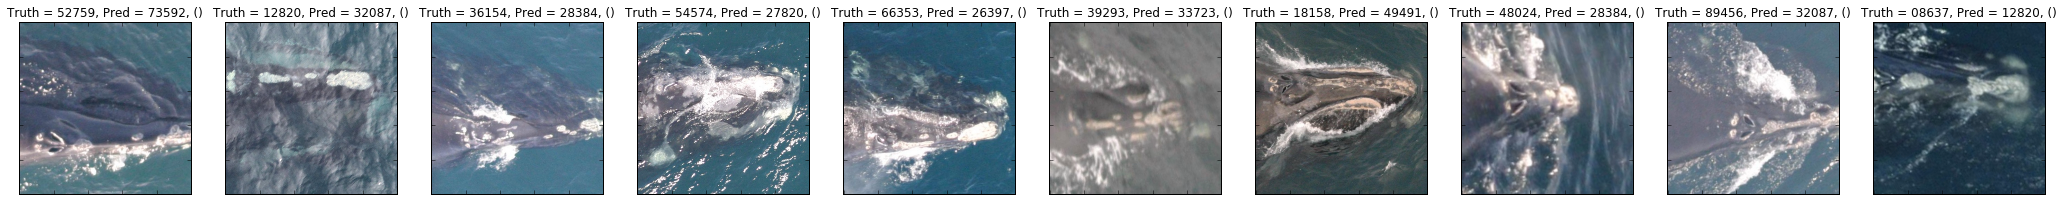

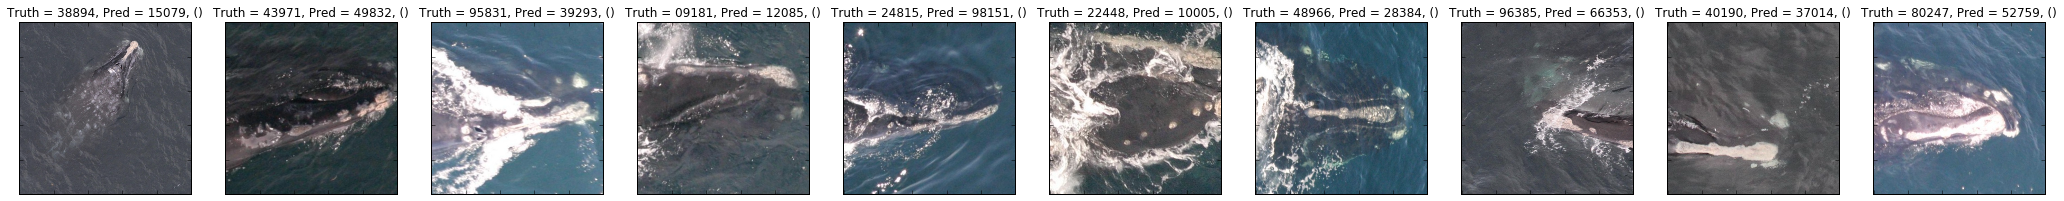

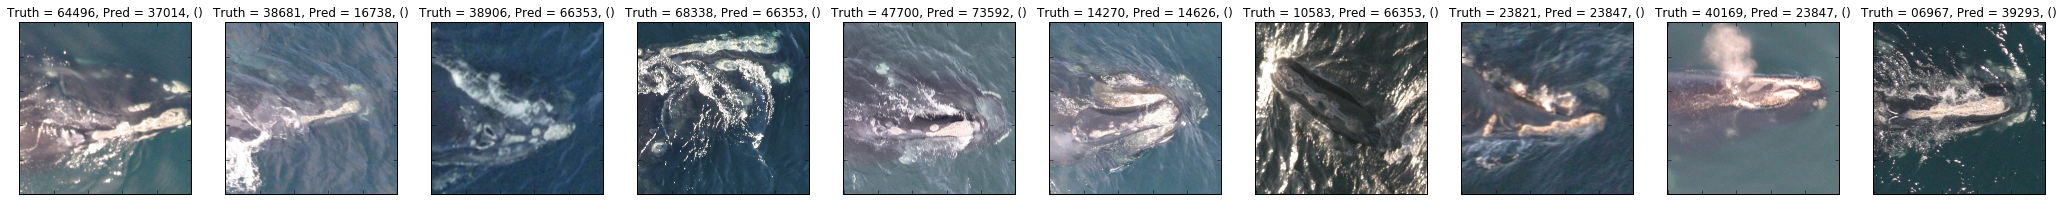

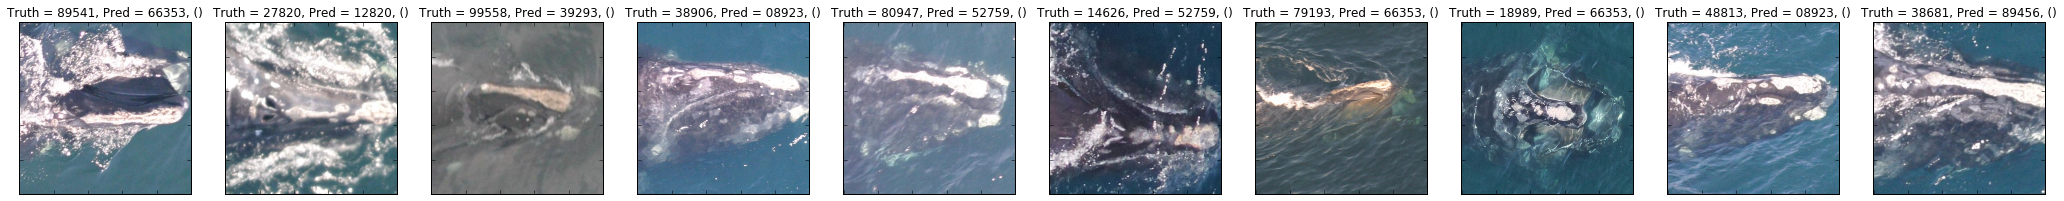

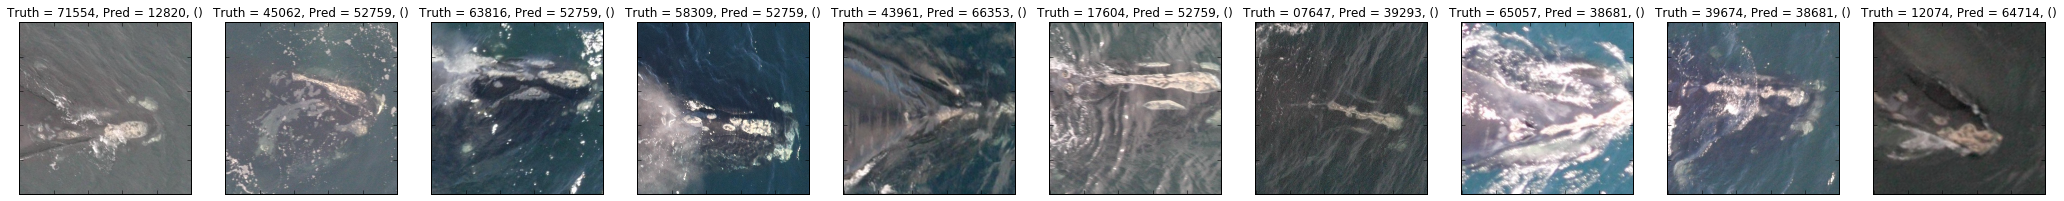

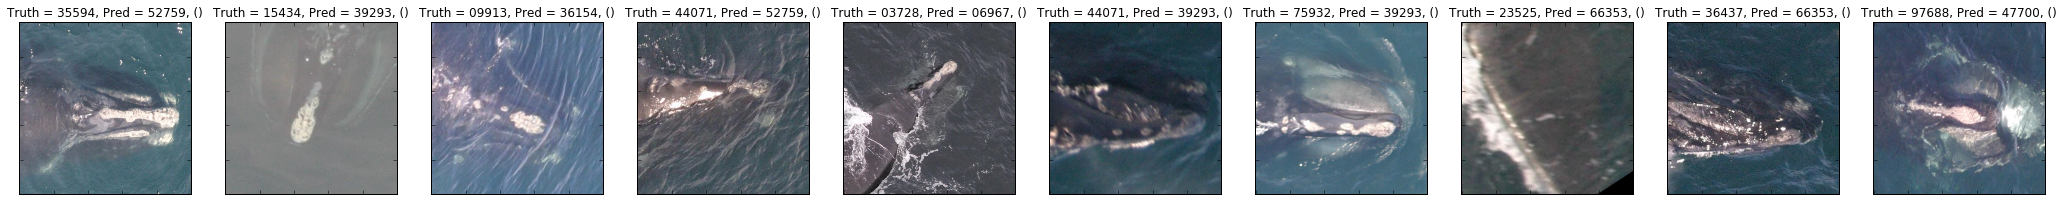

KeyboardInterrupt: 

In [3]:
if __name__ == "__main__":
    count = 0
    for epoch in xrange(nEpochs):
        print("Epoch {0} of {1}".format(epoch,nEpochs))
        for trTe in ["train"]:
            if epoch > 0:
                load = 1 # Must have a model to load by 2nd epoch... so load it !
                tf.reset_default_graph()
            x, y, yPaths, yPred, ce, correct, accuracy, trainStep, learningRate = nodes(trTe)
            [varSummary(var) for var in [ce,accuracy]] # Summaries
            merged = tf.summary.merge_all()
            saver = tf.train.Saver()
            with tf.Session() as sess:
                if load == 1:
                    saver.restore(sess,modelName)
                writer = tf.summary.FileWriter("summary/{0}".format(trTe),sess.graph)
                tf.global_variables_initializer().run()
                tf.local_variables_initializer().run()
                coord = tf.train.Coordinator()
                threads = tf.train.start_queue_runners(sess=sess,coord=coord)    
                try:
                    while True:      
                        if trTe == "train":
                            _,summary,x_, y_,yPred_,yPaths_ = sess.run([trainStep,merged,x,y,yPred,yPaths],feed_dict={learningRate:lr})
                            writer.add_summary(summary,count)
                            count += 1
                            if np.random.uniform() < 0.01:
                                label2Name.displayBatch(x_,yPred_=yPred_,y_=y_)
                        if coord.should_stop():
                            break
                except Exception, e:
                    coord.request_stop(e)
                finally:
                    coord.request_stop()
                    coord.join(threads)
                saver.save(sess,modelName)
                sess.close()